### Clustering con K-Means

1. Importación de librerías y carga de dataset.
2. Exploración del dataset
3. Crear una matriz de correlación para ver cuáles pueden ser las variables más relevantes.
4. Crear uno o varios scatter plot que contendrá lo siguiente:
   1. Una variable independiente en el eje x
   2. Otra variable independiente en el eje y
   3. Un color diferente para cada cluster que se quiera intentar predecir (el hue)
   
5. Procedemos a realizar los clusters con k-means.
6. Entrenamos el modelo de k-means.
7. Normalmente la columna que se intenta predecir no la tendríamos... Pero al ser ejercicios, la convertimos a numérica.
8. Creamos una columna para el cluster asignado. 
9. Recordamos que las etiquetas del k-means se guardan en el atributo `labels_`: kmeans.labels_
   
10. Importamos y creamos una matriz de confusión -> confusion_matrix(df['Cluster'],kmeans.labels_)
11. Hacemos un informe de clasificación -> classification_report(df['Cluster'],kmeans.labels_)

12. Realizamos el método del codo (aquí utilizamos el WCC en la Y y el número de clusters en la X)
13. Realizamos el método de la silueta (se mide como de cerca está un grupo de otro. 0 muy cerca, 1 muy lejos)

In [1]:
import keras
import scikeras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

En este ejercicio vamos a intentar clasficar con k-means el dataset de churn_Modelling.csv para ver si somos capaces de identificar a los clientes que se van a ir o tienen algún perfil

In [4]:
df = pd.read_csv('./iris.csv', index_col=0)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 5.1 to 5.9
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_width   150 non-null    float64
 1   petal_length  150 non-null    float64
 2   petal_width   150 non-null    float64
 3   species       150 non-null    object 
dtypes: float64(3), object(1)
memory usage: 5.9+ KB


In [17]:
#Quitar columnas que no sean relevantes

df = df.drop(['Surname', 'CustomerId'], axis=1)

In [19]:
#TODO Separamos los categóricos de los numéricos

categorical_features = ['species']
numerical_features = [
    'CreditScore','Age', 'Tenure', 'Balance', 
    'NumOfProducts', 'HasCrCard', 'IsActiveMember']

#TODO Definimos la columna de salida
target = 'Exited'

### Transformacion de categóricos

Comenzamos transformando la variable dependiente

In [6]:
# En caso de que vayamos a trabajar con redes neuronal, la variable dependiente pasaría por OneHotEncoder también para la salida

le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])
df.head()

,sepal_width,petal_length,petal_width,species
sepal_length,,,,
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0


In [20]:
#TODO Codificación de los categóricos para la matriz de correlación
# LabelEncoder para la Y
# OrdinalEncoder y OneHotEncoder para la X


one_hot_encoder = OneHotEncoder(drop='first', sparse_output=True)
encoded_data = one_hot_encoder.fit_transform(df[categorical_features])

encoded_data = encoded_data.toarray()
#Nombres de las columnas
feature_names = one_hot_encoder.get_feature_names_out()

#Creamos un dataframe con los datos codificados
df_encoded = pd.DataFrame(encoded_data, columns=feature_names)
df_encoded

,Geography_Germany,Geography_Spain,Gender_Male
0,0.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
9995,0.0,0.0,1.0
9996,0.0,0.0,1.0
9997,0.0,0.0,0.0
9998,1.0,0.0,1.0


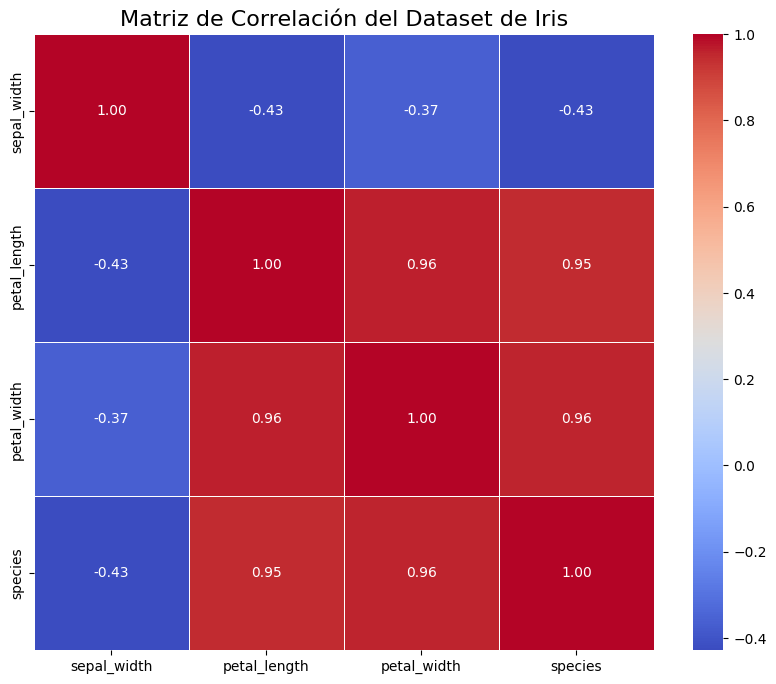

In [9]:
# Calcular la matriz de correlación de las variables numéricas
correlation_matrix = df.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Añadir un título
plt.title('Matriz de Correlación del Dataset de Iris', fontsize=16)

# Mostrar la figura
plt.show()



## Información clave:

Aquí podemos ver información clave, las correlaciones para Exited están en:

In [13]:
feature_1 = "sepal_width"

feature_2 = "petal_length"

feature_3 = "petal_width"

target = "species"

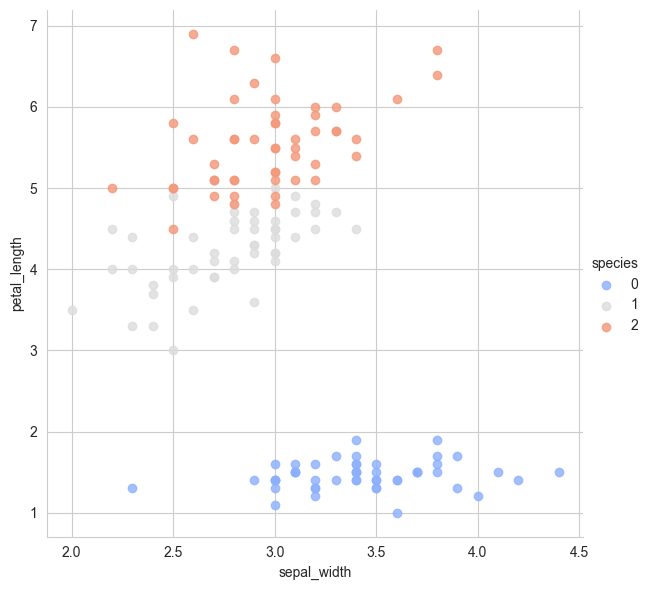

In [14]:
sns.set_style('whitegrid')
sns.lmplot(x=feature_1,y=feature_2,data=df, hue=target,
           palette='coolwarm',height=6,aspect=1,fit_reg=False)

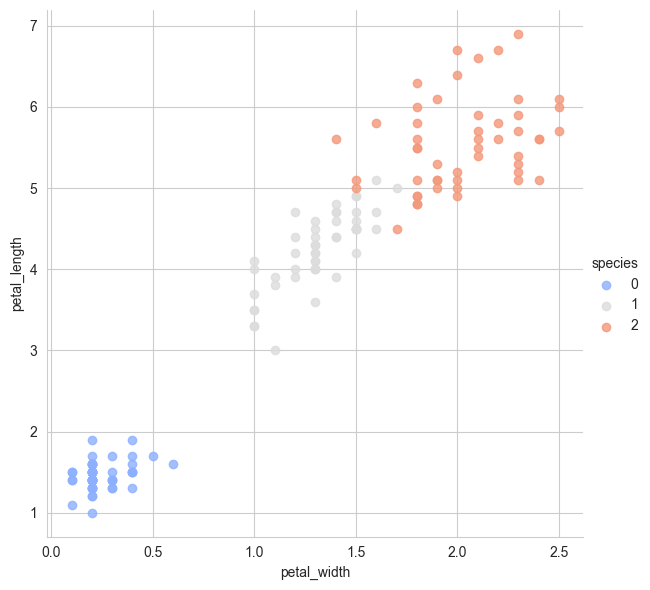

In [15]:
sns.set_style('whitegrid')
sns.lmplot(x=feature_3,y=feature_2,data=df, hue=target,
           palette='coolwarm',height=6,aspect=1,fit_reg=False)

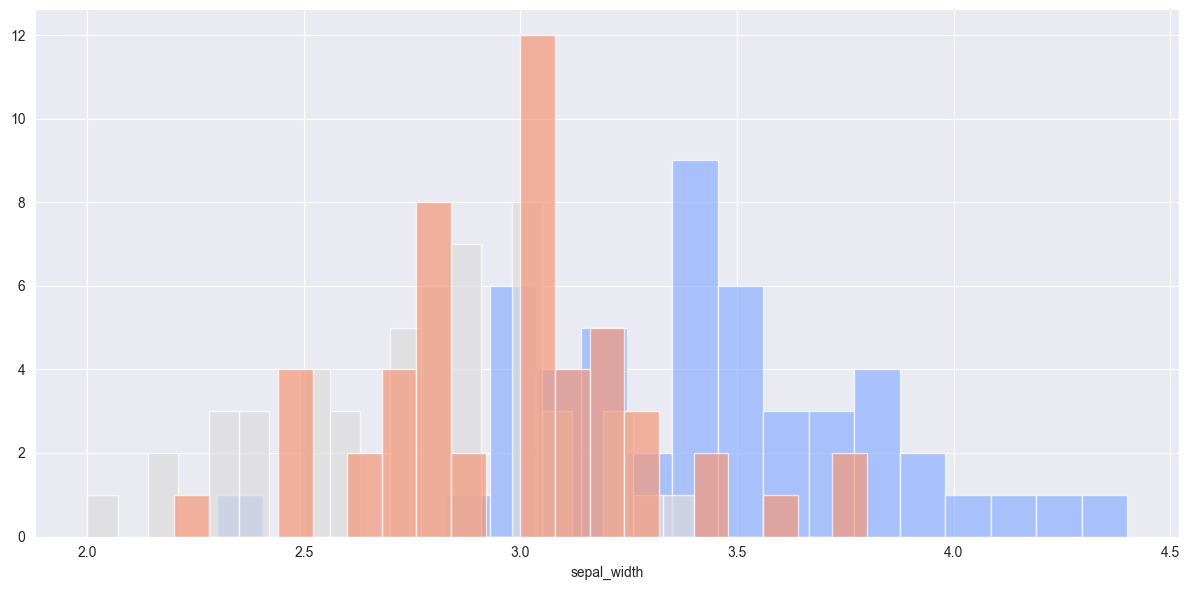

In [18]:
sns.set_style('darkgrid')
g = sns.FacetGrid(df,hue=target,palette='coolwarm',height=6,aspect=2)
g = g.map(plt.hist, feature_1 ,bins=20,alpha=0.7)

<Axes: xlabel='petal_length', ylabel='count'>

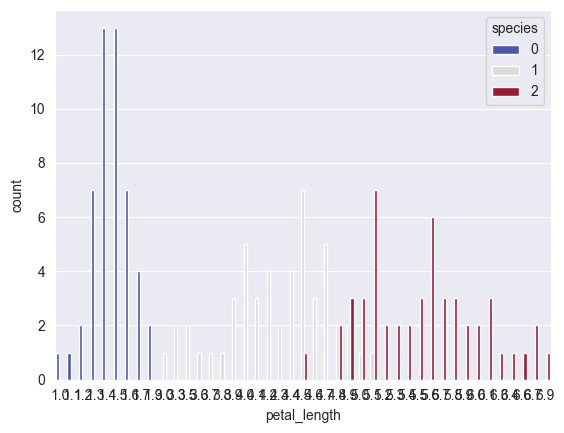

In [17]:
sns.countplot(x=feature_2, hue=target, data=df, palette='coolwarm')

<Axes: xlabel='petal_width', ylabel='count'>

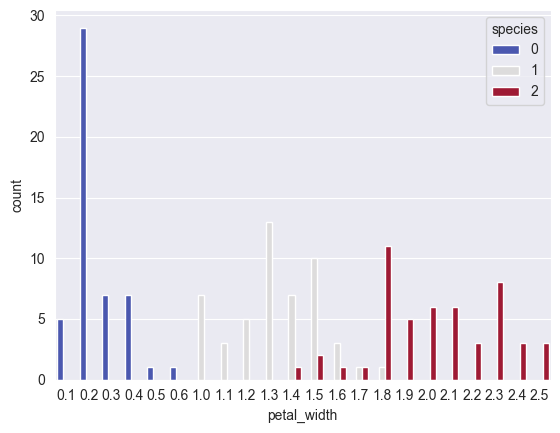

In [19]:
sns.countplot(x=feature_3, hue=target, data=df, palette='coolwarm')

In [21]:
df_copy = df.copy()

## Creación del clúster K Means

¡Ahora es el momento de crear las etiquetas de clúster!

1. Importamos e instanciamos el Kmeans con n clusters.
2. Entrenamos el modelo SIN la variable dependiente.
3. Graficamos el original y el clusterizado.
4. Imprimimos los centros de cada clusters y podemos hacer un head -opcional.
5. Imprimimos la matriz de confusión y las métricas.

In [22]:
from sklearn.cluster import KMeans

Sabiendo que tenemos tres categorías, entrenar con dos clusters no tiene sentido, aunque puede ser una buena idea para ver cómo funciona y darnos cuenta de que no es la mejor opción.

In [23]:
kmeans = KMeans(n_clusters=2)


In [25]:
#df.dropna(inplace=True)
kmeans.fit(df.drop(target,axis=1))

KMeans(n_clusters=2)

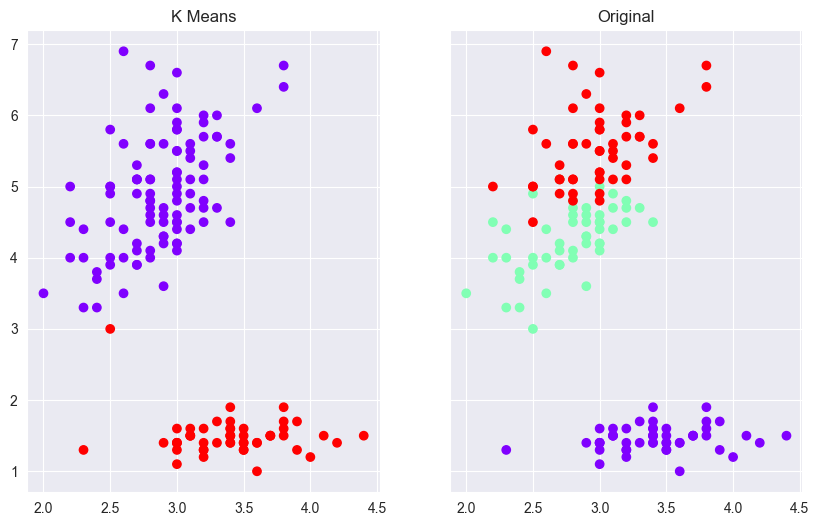

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,6))

# Gráfico de KMeans
ax1.set_title('K Means')
ax1.scatter(df.iloc[:, 0], df.iloc[:, 1], c=kmeans.labels_, cmap='rainbow')

# Gráfico original
ax2.set_title("Original")
ax2.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df[target], cmap='rainbow')

plt.show()

Si no hemos aplicado el LabelEncoder o el OneHot, ahora es el momento.

In [38]:
# def converter(cluster):
#     if cluster=='Yes':
#         return 1
#     else:
#         return 0

# df['Cluster'] = df['Exited'].apply(converter)

In [28]:
kmeans.cluster_centers_

array([[2.87575758, 4.92525253, 1.68181818],
       [3.40980392, 1.49215686, 0.2627451 ]])

In [29]:
df.head()

,sepal_width,petal_length,petal_width,species
sepal_length,,,,
5.1,3.5,1.4,0.2,0
4.9,3.0,1.4,0.2,0
4.7,3.2,1.3,0.2,0
4.6,3.1,1.5,0.2,0
5.0,3.6,1.4,0.2,0


In [33]:
from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(df[target],kmeans.labels_))

print(confusion_matrix(df[target],kmeans.labels_))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.02      0.02      0.02        50
           2       0.00      0.00      0.00        50

    accuracy                           0.01       150
   macro avg       0.01      0.01      0.01       150
weighted avg       0.01      0.01      0.01       150

[[ 0 50  0]
 [49  1  0]
 [50  0  0]]


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

### Aumentamos a 3 el número de clusters

In [36]:

kmeans = KMeans(n_clusters=3)
kmeans.fit(df.drop(target,axis=1))

print(classification_report(df[target],kmeans.labels_))
print(confusion_matrix(df[target],kmeans.labels_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.85      1.00      0.92        50
           2       1.00      0.82      0.90        50

    accuracy                           0.94       150
   macro avg       0.95      0.94      0.94       150
weighted avg       0.95      0.94      0.94       150

[[50  0  0]
 [ 0 50  0]
 [ 0  9 41]]


### Hacemos la gráfica del codo

In [34]:
X = df.drop([target],axis=1)

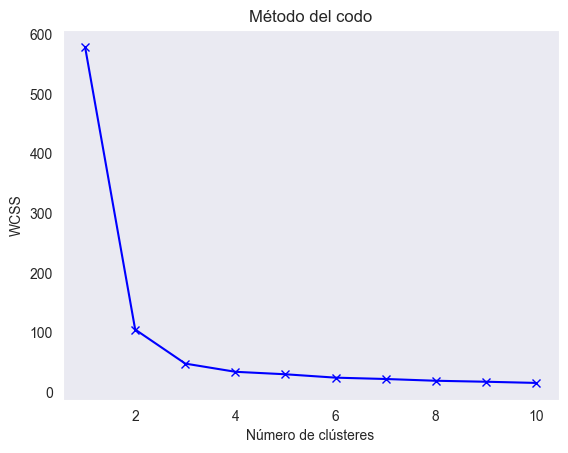

In [35]:

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss,"bx-")
plt.grid()
plt.title('Método del codo')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

# Aplicamos el método de la silueta

In [41]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


### Reducción de dimensionalidad

podemos empezar haciendo una PCA para reducirlo a dos componentes principales

In [37]:
from sklearn.decomposition import PCA

X = df.drop([target],axis=1)
y = df[target]

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)


In [43]:
# OPCIÓN 2: Utilizar todas las variables

X = df.drop([target],axis=1)
y = df[target]

In [38]:
# Creamos una copia de seguridad
X_copy = X.copy()
X = X_pca

Para n_clusters = 2 la silhouette_score media es : 0.7292156279698696
Para n_clusters = 3 la silhouette_score media es : 0.5924993417660823
Para n_clusters = 4 la silhouette_score media es : 0.5330003216272164
Para n_clusters = 5 la silhouette_score media es : 0.39113404933716145
Para n_clusters = 6 la silhouette_score media es : 0.35913207274640874


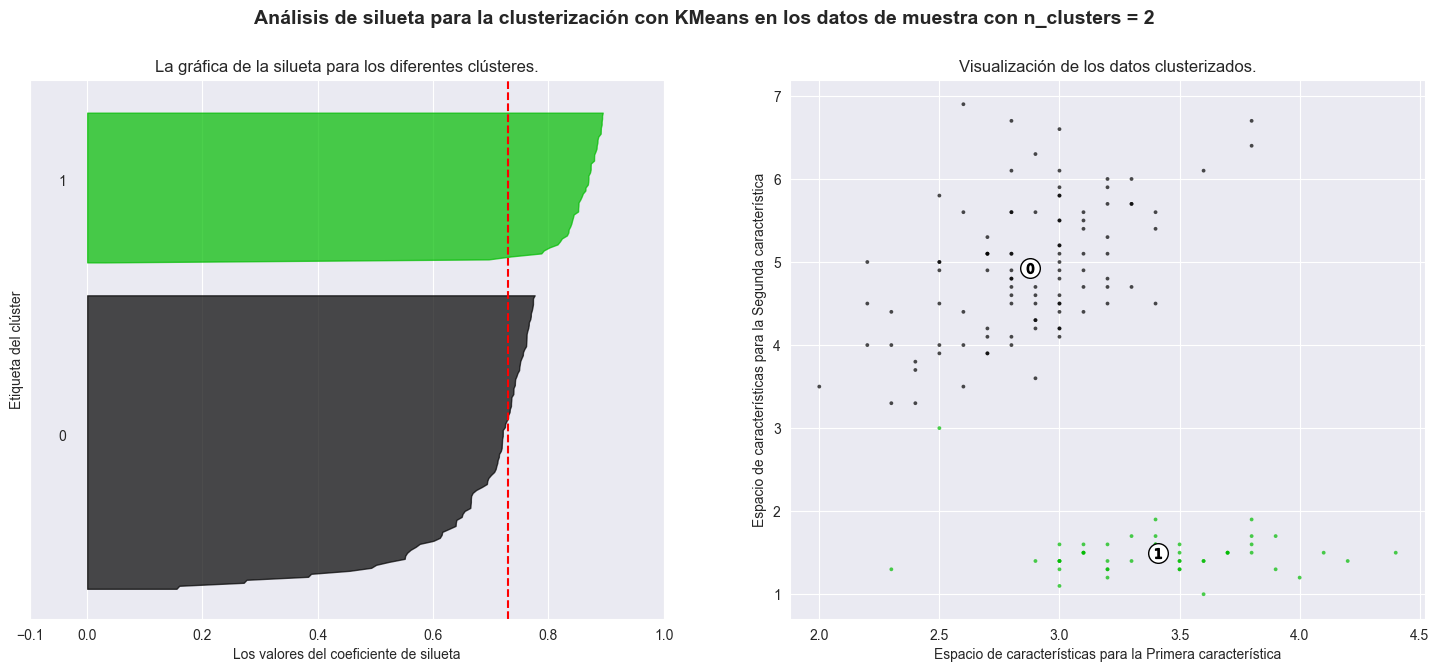

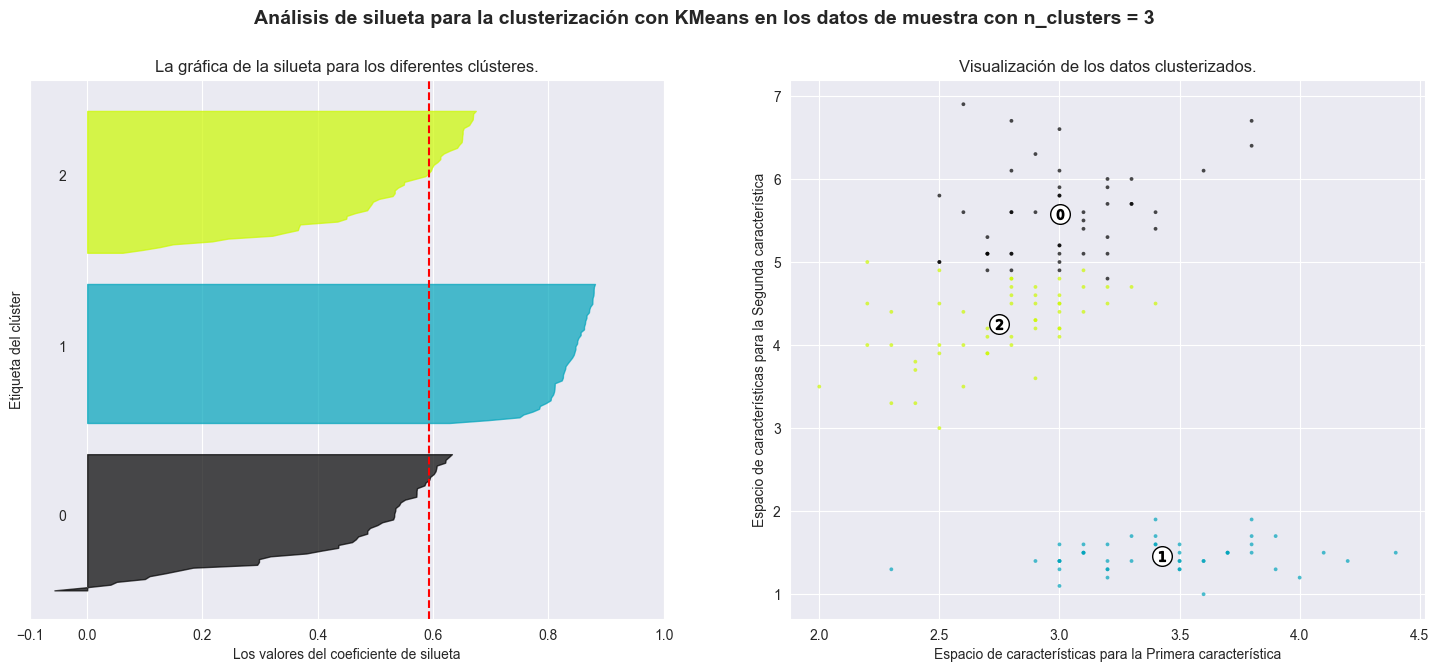

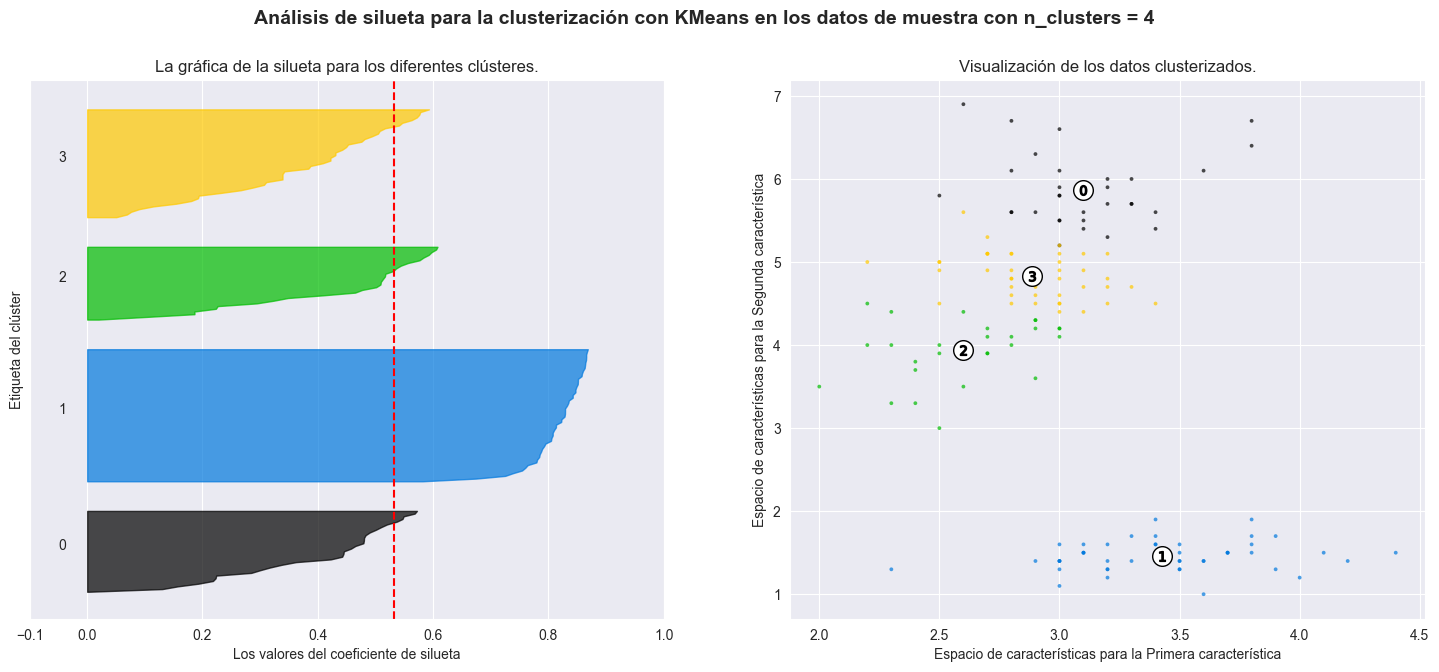

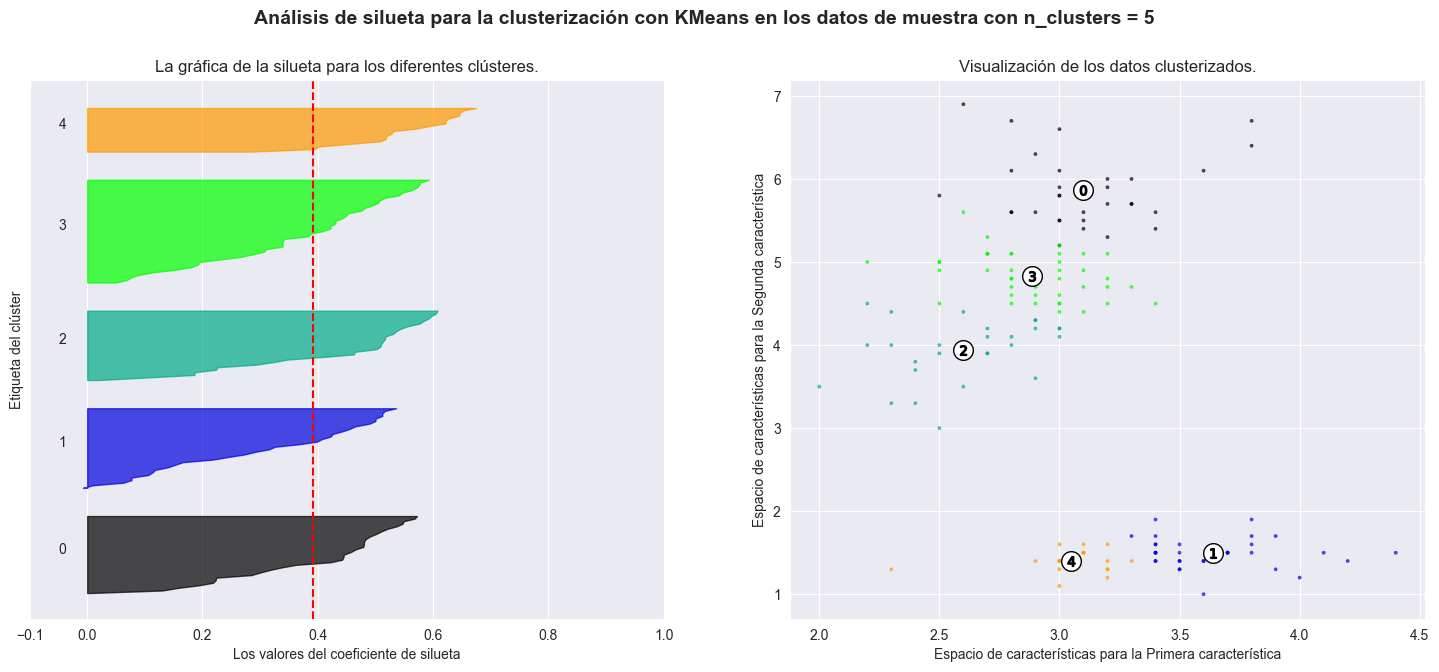

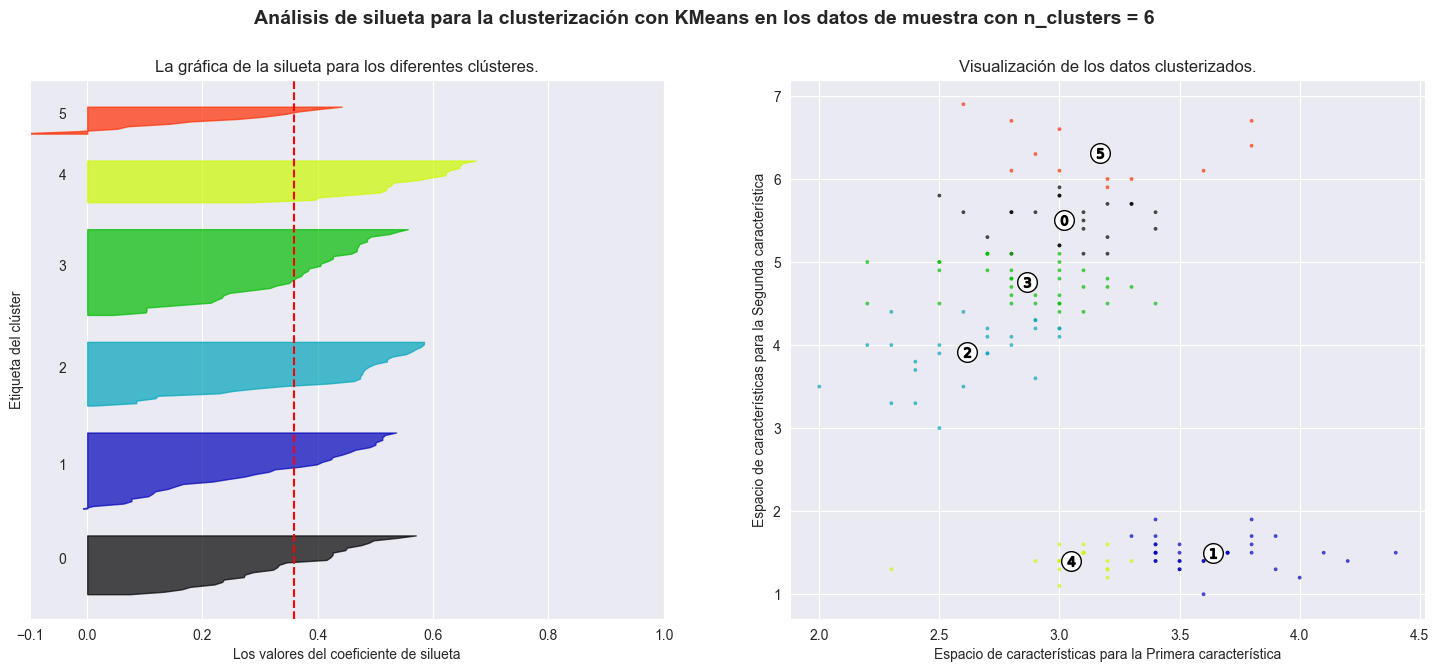

In [45]:
# Ahora sí, comenzamos con el análisis de silueta con nuestra X e Y definidas

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Creamos un bubplot con 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # El primer subplot es el plot de la silueta
    # El coeficiente de silueta puede oscilar entre -1 y 1 pero en este ejemplo
    # están en [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # La fórmula (n_clusters+1)*10 es para insertar espacios en blanco entre siluetas
    # de los clúster individuales, con el objetivo de separarlos de forma clara.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Inicializamos el clusterizador con el valor n_clusters y una semilla generadora
    # de forma aleatoria de 10 para poder volverlo hacer igual.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # silhouette_score nos da el valor medio de todas las muestras.
    # Este proporciona una perspectiva de densidad y separación de los
    # clústeres formados
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "la silhouette_score media es :", silhouette_avg)

    # Calculamos la puntuación de la silueta para cada muestra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Agrega las puntuaciones de la silueta para las muestras que pertenecen al clúster i,
        # y las clasifica
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiqueta la gráfica de siluetas con el número del clúster en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcula la nueva y_lower para la siguiente gráfica
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("La gráfica de la silueta para los diferentes clústeres.")
    ax1.set_xlabel("Los valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del clúster")

    # La línea vertical de la puntuación de la silueta media de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Limpia el eje y (etiquetas / ticks)
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # UTILIZAR UNA FORMA U OTRA DEPENDIENDO DE SI ES UN DATAFRAME DE PANDAS O NO
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #! ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #!             c=colors, edgecolor='k')
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

    # Etiquetado de los clústeres
    centers = clusterer.cluster_centers_
    # Pintamos círculos blancos en los centros de los clústeres
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualización de los datos clusterizados.")
    ax2.set_xlabel("Espacio de características para la Primera característica")
    ax2.set_ylabel("Espacio de características para la Segunda característica")

    plt.suptitle(("Análisis de silueta para la clusterización con KMeans en los datos de muestra "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Interpretando el método de la silueta

-El grueso de cada barra es el tamaño del cluster.

-Todo lo que sobresalga de 1 es un cluster muy bien definido y separado de los vecinos.

-Todo lo que está entre 0 y 1 está relativamente cerca de sus vecinos -cuanto más cerca de 0, más cerca de los vecinos.

-Los número snegativos indican que está mal clasificado.